In [304]:
# store start time to get execution time of entire script
import time
start_time = time.time()

In [305]:
# helper functions for displaying table data

import numpy as np
from IPython.display import display_html

# n is the number of columns to display data in
def display_side_by_side(series_obj, n):
    df = pd.DataFrame(series_obj)
    partition = int(round(len(df) / n))
    lower_bound = 0
    upper_bound = partition
    args = []
    for i in range(n):
        args.append(df[lower_bound:upper_bound])
        lower_bound += partition
        upper_bound += partition
    helper(args)

def helper(args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [306]:
# helper function for plotting out ground truth curves

import matplotlib.pyplot as plt
plt.rcParams["font.weight"] = "bold"

def get_ground_truth(data):
    relapsed = data[data.Illicit_Cens5 == 1]
    counts = relapsed['Illicit_Days5'].value_counts()
    counts = counts.to_dict()
    temp = [len(data)] * 365
    labels = list(range(365))
    for i in range(365):
        labels[i] += 1
    total = 0
    errors = []
    for i in range(365):
        try:
            temp[i] = temp[i] - counts[i+1] - total
            total = total + counts[i+1]
        except KeyError:
            errors.append(i)

    for ele in sorted(errors, reverse = False):
        if ele != 0:
            temp[ele] = temp[ele-1]
        else:
             temp[0] = len(data)
    temp = [x / len(data) for x in temp]
    return labels, temp

In [307]:
from sklearn.model_selection import cross_validate
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.linear_model import CoxnetSurvivalAnalysis

def run_models(X, y, label):
    rsf = RandomSurvivalForest()
    scores = cross_validate(rsf, X, y, cv=5)
    rsf_score = scores['test_score'].mean()
    print('RF score:', rsf_score)
    
    rsf = RandomSurvivalForest()
    rsf.fit(X, y)
    
    # l1_ratio = 1 adjusts model to implement LASSO method for penalties
    rcr = CoxnetSurvivalAnalysis(l1_ratio=1)
    scores = cross_validate(rcr, X, y, cv=5)
    rcr_score = scores['test_score'].mean()
    print('Lasso score:', rcr_score)
    
    # fit_baseline_model = True allows us to create survival/hazard plots after model is fit
    rcr = CoxnetSurvivalAnalysis(fit_baseline_model=True, l1_ratio=1)
    rcr.fit(X, y)
    
    # concordance index
    scores = {'Model': ['Random Forest','Lasso','Dataset Size'], 
              label: [rsf_score,rcr_score,X.shape[0]]}
    
    concordance = pd.DataFrame(data=scores)
    
    # return scores and models
    return concordance

In [308]:
def get_survival_graph(rsf, rcr, X, Y, label, filename):
    pred_surv_rsf = rsf.predict_survival_function(X)
    pred_surv_rcr = rcr.predict_survival_function(X)
    
    # display survival plot
    plt.suptitle(label)
    plt.plot(np.mean([person for person in pred_surv_rsf], axis=0), label='RF')
    plt.plot(np.mean([person.y for person in pred_surv_rcr], axis=0), label='Lasso')
    labels, temp = get_ground_truth(Y)
    plt.plot(labels, temp, label='Ground Truth')
    plt.legend()
    plt.xlim(0, 365)
    plt.xticks(np.arange(0, 365, step=50))
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.savefig(filename)
        
    plt.show()

In [309]:
from tqdm.notebook import tqdm # used to show progress bar

def get_feature_importance(X, y, rsf, rcr, label):
    # feature importances from Random Forest
    feature_importance_rf = pd.DataFrame({'Feature':list(X.columns),})
    feature_importance_rf[label] = 0
    
    scores = cross_validate(rsf, X, y, cv=5)
    reference = scores['test_score'].mean()
    
    for i,row in tqdm(feature_importance_rf.iterrows(), total=feature_importance_rf.shape[0]):
        feat = row['Feature']
        temp_data = X.copy()
        temp_data[feat] = np.random.permutation(temp_data[feat].values)        
        temp_scores = cross_validate(rsf, temp_data, y, cv=5)
        temp_score = temp_scores['test_score'].mean()
        feature_importance_rf.iloc[i, feature_importance_rf.columns.get_loc(label)] = reference - temp_score

    feature_importance_rf.sort_values(by=[label], ascending=False, inplace=True)
    feature_importance_rf = feature_importance_rf.nlargest(10,[label]) # keep top 10 features
    feature_importance_rf = feature_importance_rf[feature_importance_rf[label] != 0]

    # feature importances from Lasso
    feature_importance_lasso = pd.DataFrame({'Feature':list(X.columns), #temp,
                                                  label:np.average(rcr.coef_, weights=rcr.alphas_, axis = 1),})
    feature_importance_lasso[label] = np.exp(feature_importance_lasso[label])
    feature_importance_lasso[label + '_abs'] = np.absolute(feature_importance_lasso[label])
    feature_importance_lasso = feature_importance_lasso.nlargest(10,[label + '_abs']) # keep top 10 features
    feature_importance_lasso = feature_importance_lasso[feature_importance_lasso[label] != 0]
    
    return feature_importance_rf, feature_importance_lasso

Survival Analysis by Severity

In [310]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import csv

df = pd.read_csv('data/data_superset_stratified.csv')    
df.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,ID,State,City,agyaddr,xobsyr_0,Illicit_Days5,Illicit_Cens5,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,srprobg_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,primsev_cd_1,primsev_cd_2,primsev_cd_3,primsev_cd_4,primsev_cd_5,primsev_cd_6,B2a_0g,SUDSy_0,Address,lat,lng,state_name,county_FIPS,block_FIPS,murder_numg,%_dropoutg,%_povertyg,%_public_assistanceg,%_unemployedg,closest,gran,point,pop_deng
0,0,1,2,929,OH,Cleveland,1276 West Third St. #400,2006,354,0,0,0,0,0,1,0,1,0,1,0,1,1,0,1,0,2,1,0,0,0,0,0,0,3,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,Ohio,39035.0,3.903511e+14,0,0.0,0.0,0.0,0.0,NaN,1.0,"('41.501028000000005', '-81.697772')",0.0
1,1,2,3,951,OH,Cleveland,1276 West Third St. #400,2006,365,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,2,0,0,1,0,0,0,0,2,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,Ohio,39035.0,3.903511e+14,0,0.0,0.0,0.0,0.0,NaN,1.0,"('41.501028000000005', '-81.697772')",0.0
2,2,3,4,1032,OH,Cleveland,1276 West Third St. #400,2006,365,0,0,0,0,0,2,0,1,1,1,1,1,0,2,1,0,2,0,0,1,0,0,0,0,2,"1276 West Third St. #400, Cleveland, OH",41.501028,-81.697772,Ohio,39035.0,3.903511e+14,0,0.0,0.0,0.0,0.0,NaN,1.0,"('41.501028000000005', '-81.697772')",0.0
3,3,18,19,1673,KY,Louisville,1220 Bardstown Rd,2006,365,0,0,0,0,0,0,0,0,0,1,1,0,0,2,2,0,0,0,0,1,0,0,0,0,2,"1220 Bardstown Rd, Louisville, KY",38.236398,-85.717815,Kentucky,21111.0,2.111101e+14,0,0.0,0.0,0.0,0.0,NaN,1.0,"('38.236397499999995', '-85.7178152')",0.0
4,4,21,22,3870,AZ,Tucson,3130 E Broadway Blvd,2006,5,1,0,0,0,1,2,1,2,2,2,1,2,1,1,2,2,2,0,0,1,0,0,0,0,11,"3130 E Broadway Blvd, Tucson, AZ",32.221465,-110.926070,Arizona,4019.0,4.019002e+13,0,0.0,0.0,0.0,0.0,NaN,1.0,"('32.2214651', '-110.92607029999999')",0.0


In [311]:
# drop unnecessary columns
cols_to_drop = ['Address','lat','lng','xobsyr_0','Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1',
                'ID','State','City','agyaddr','state_name','gran','srprobg_cd','county_FIPS','block_FIPS',
                'point','closest']

df.drop(columns=cols_to_drop, inplace=True)
df.dropna(inplace=True) # drops any remaining rows with null values

# uncomment to get CONTROL statistics
#cols_to_drop = ['pop_deng','%_dropoutg','%_unemployedg','%_public_assistanceg','%_povertyg','murder_numg']
#df.drop(columns=cols_to_drop, inplace=True)

df = df.astype(int)
df = df.sample(frac=1).reset_index(drop=True) # shuffle rows
df.shape

(10068, 31)

In [312]:
lasso_selected_features = ["%_povertyg","%_unemployedg","SESg_0_cd","SUDSy_0","cdsg_0_cd","cjsig_0_cd","dssg_0_cd",
                           "gvsg_cd","nonwhite_cd","primsev_cd_3","primsev_cd_4","primsev_cd_5","primsev_cd_6",
                           "prsatx_cd","r4ag_0_cd","srig_0_cd","%_public_assistanceg"]

In [313]:
df.head()

,Illicit_Days5,Illicit_Cens5,female_cd,nonwhite_cd,unemplmt_cd,prsatx_cd,gvsg_cd,CWSg_0_cd,dssg_0_cd,epsg_0_cd,adhdg_0_cd,cdsg_0_cd,cjsig_0_cd,lrig_0_cd,srig_0_cd,SESg_0_cd,r4ag_0_cd,primsev_cd_1,primsev_cd_2,primsev_cd_3,primsev_cd_4,primsev_cd_5,primsev_cd_6,B2a_0g,SUDSy_0,murder_numg,%_dropoutg,%_povertyg,%_public_assistanceg,%_unemployedg,pop_deng
0,189,0,0,1,0,0,1,0,1,1,1,1,1,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0
1,365,0,0,1,1,0,0,0,0,0,0,0,0,1,2,1,0,0,0,1,0,0,0,1,2,1,0,0,0,0,0
2,365,0,0,1,0,1,1,0,2,1,1,1,2,1,2,0,1,0,0,0,0,0,1,1,7,0,0,0,0,0,0
3,181,0,0,1,1,0,0,0,0,0,0,0,0,1,2,0,2,0,0,1,0,0,0,2,1,0,0,0,0,0,0
4,182,0,0,1,0,0,2,0,1,1,1,0,1,1,2,1,0,0,0,1,0,0,0,1,7,1,0,1,0,0,0


Full Population Survival Analysis

In [314]:
from sklearn.model_selection import train_test_split
from sksurv.util import Surv

predictor_var = 'Illicit_Days5'
censoring_var = 'Illicit_Cens5'

X = df.copy()
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var], inplace=True)
y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(10068, 29) (10068,)


In [315]:
%%time
full_concordance = run_models(X, y, 'ALL')
rsf = RandomSurvivalForest().fit(X, y)
rcr = CoxnetSurvivalAnalysis(l1_ratio=1, fit_baseline_model=True).fit(X, y)

RF score: 0.6705150626942372
Lasso score: 0.6791487811625555
CPU times: user 45.3 s, sys: 4.86 s, total: 50.2 s
Wall time: 54.3 s


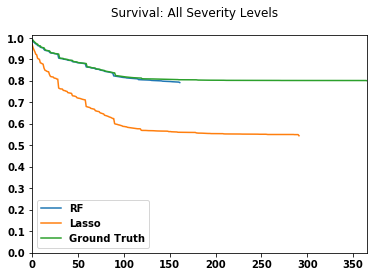

In [316]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: All Severity Levels','graphs/survival_all.png')

Subclinical Severity Survival Analysis

In [317]:
X = df[df.SUDSy_0 < 2]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(3250, 28) (3250,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [318]:
%%time
subclinical_concordance = run_models(X, y, 'SUB')
rsf = RandomSurvivalForest().fit(X, y)
rcr = CoxnetSurvivalAnalysis(l1_ratio=1, fit_baseline_model=True).fit(X, y)

RF score: 0.6612033971463577
Lasso score: 0.676751465582204
CPU times: user 12.1 s, sys: 895 ms, total: 13 s
Wall time: 14.1 s


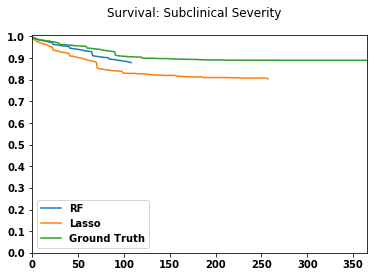

In [319]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Subclinical Severity', 'graphs/survival_subclinical.png')

In [320]:
%%time
subclinical_feature_importance_rf, subclinical_feature_importance_lasso = \
                                        get_feature_importance(X, y, rsf, rcr, 'SUB')


CPU times: user 3min 5s, sys: 7.77 s, total: 3min 12s
Wall time: 3min 34s


Mild/Moderate Severity Survival Analysis

In [321]:
X = df[df.SUDSy_0 >= 2]
X = X[X.SUDSy_0 <= 5]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(2838, 28) (2838,)


In [322]:
%%time
mild_concordance = run_models(X, y, 'MILD')
rsf = RandomSurvivalForest().fit(X, y)
rcr = CoxnetSurvivalAnalysis(l1_ratio=1, fit_baseline_model=True).fit(X, y)

RF score: 0.5873844361028607
Lasso score: 0.6009682086883436
CPU times: user 10.9 s, sys: 682 ms, total: 11.6 s
Wall time: 12.3 s


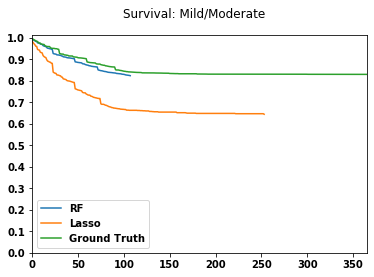

In [323]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Mild/Moderate', 'graphs/survival_mild.png')

In [324]:
%%time
mild_feature_importance_rf, mild_feature_importance_lasso = get_feature_importance(X, y, rsf, rcr, 'MILD')


CPU times: user 2min 53s, sys: 7.9 s, total: 3min 1s
Wall time: 3min 16s


Severe Severity Survival Analysis

In [325]:
X = df[df.SUDSy_0 > 5]
Y = X[[censoring_var, predictor_var]]
X.drop(columns=[censoring_var, predictor_var, 'SUDSy_0'], inplace=True)

y = Surv.from_arrays(Y[censoring_var], Y[predictor_var]) # structured array to ensure correct censoring

print(X.shape, y.shape)

(3980, 28) (3980,)


//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [326]:
%%time
severe_concordance = run_models(X, y, 'SEVERE')
rsf = RandomSurvivalForest().fit(X, y)
rcr = CoxnetSurvivalAnalysis(l1_ratio=1, fit_baseline_model=True).fit(X, y)

RF score: 0.6083428414114158
Lasso score: 0.6144686021883905
CPU times: user 15.2 s, sys: 1.11 s, total: 16.3 s
Wall time: 16.1 s


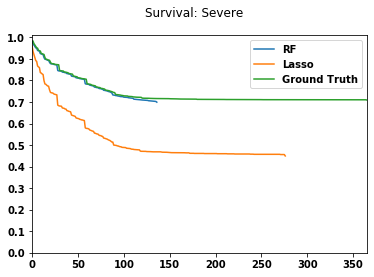

In [327]:
get_survival_graph(rsf, rcr, X, Y, 'Survival: Severe', 'graphs/survival_severe.png')

In [328]:
%%time
severe_feature_importance_rf, severe_feature_importance_lasso = get_feature_importance(X, y, rsf, rcr, 'SEVERE')


CPU times: user 4min 12s, sys: 20.5 s, total: 4min 32s
Wall time: 4min 57s


Overall Statistics

In [329]:
overall_concordance = pd.concat([subclinical_concordance, mild_concordance['MILD'], severe_concordance['SEVERE'],  
                                 full_concordance['ALL']], axis=1)
pd.DataFrame(data=overall_concordance).round(4)

,Model,SUB,MILD,SEVERE,ALL
0,Random Forest,0.6612,0.5874,0.6083,0.6705
1,Lasso,0.6768,0.6010,0.6145,0.6791
2,Dataset Size,3250.0000,2838.0000,3980.0000,10068.0000


In [330]:
overall_feature_importance_lasso = pd.merge(subclinical_feature_importance_lasso, \
                                            mild_feature_importance_lasso, on='Feature', how='outer')
overall_feature_importance_lasso = pd.merge(overall_feature_importance_lasso, \
                                            severe_feature_importance_lasso, on='Feature', how='outer')
overall_feature_importance_lasso.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_lasso, 2)

,Feature,SUB,SUB_abs,MILD,MILD_abs,SEVERE,SEVERE_abs
0,cjsig_0_cd,1.179859,1.179859,0.000000,0.000000,1.002466,1.002466
1,r4ag_0_cd,1.109802,1.109802,1.096246,1.096246,1.094860,1.094860
2,gvsg_cd,1.100661,1.100661,1.023011,1.023011,0.000000,0.000000
3,B2a_0g,1.064567,1.064567,0.000000,0.000000,0.000000,0.000000
4,dssg_0_cd,1.060209,1.060209,0.000000,0.000000,1.080701,1.080701
5,%_povertyg,1.039546,1.039546,1.100141,1.100141,0.000000,0.000000
6,prsatx_cd,1.020741,1.020741,1.078502,1.078502,1.012318,1.012318
7,cdsg_0_cd,1.018637,1.018637,0.000000,0.000000,1.052429,1.052429
,Feature,SUB,SUB_abs,MILD,MILD_abs,SEVERE,SEVERE_abs
8,primsev_cd_4,1.018316,1.018316,1.031048,1.031048,0.000000,0.000000


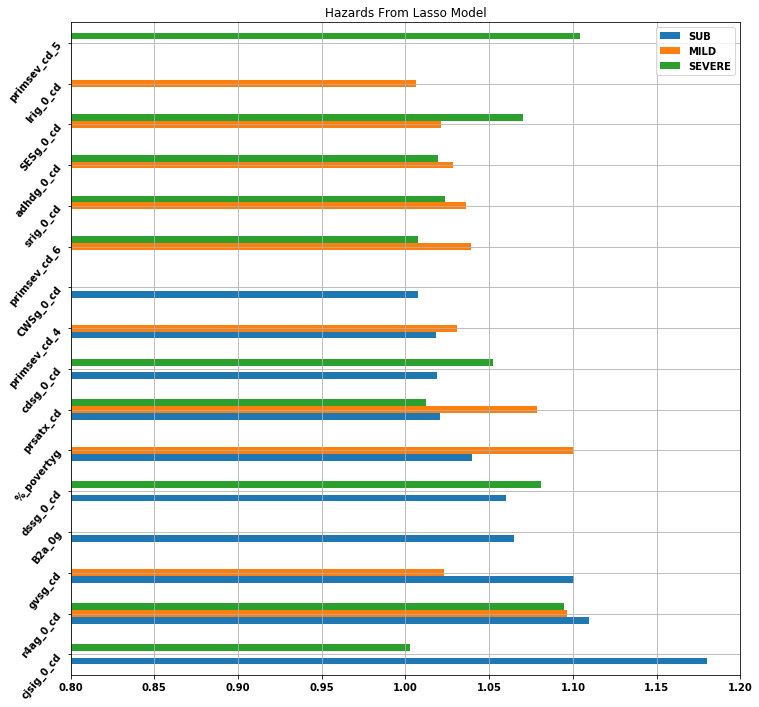

In [331]:
haz_df = pd.DataFrame({'SUB': overall_feature_importance_lasso['SUB'].tolist(),
                   'MILD': overall_feature_importance_lasso['MILD'].tolist(),
                   'SEVERE': overall_feature_importance_lasso['SEVERE'].tolist()},
                  index=overall_feature_importance_lasso['Feature'].tolist())
haz_df = haz_df.replace(1, 0)
haz_df.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = haz_df.plot.barh(rot=50, figsize=(12, 12))
ax.set_xlim([0.8,1.2])
ax.grid()
ax.set_title('Hazards From Lasso Model')
fig = ax.get_figure()

fig.savefig('graphs/hazards_lasso.png', bbox_inches='tight')

In [332]:
overall_feature_importance_rf = pd.merge(subclinical_feature_importance_rf, mild_feature_importance_rf, on='Feature', how='outer')
overall_feature_importance_rf = pd.merge(overall_feature_importance_rf, severe_feature_importance_rf, on='Feature', how='outer')
overall_feature_importance_rf.fillna(0, inplace=True)
display_side_by_side(overall_feature_importance_rf, 4)

,Feature,SUB,MILD,SEVERE
0,cjsig_0_cd,0.010900,0.000000,0.000000
1,B2a_0g,0.010011,0.009569,0.004755
2,murder_numg,0.005350,0.000000,0.000000
3,female_cd,0.003849,0.000000,0.000000
4,prsatx_cd,0.002490,-0.002746,0.000000
5,SESg_0_cd,0.001465,0.000000,0.006532
,Feature,SUB,MILD,SEVERE
6,primsev_cd_4,0.001007,0.000000,0.000000
7,nonwhite_cd,0.000362,0.000000,0.002261
8,adhdg_0_cd,0.000243,0.000000,0.000000


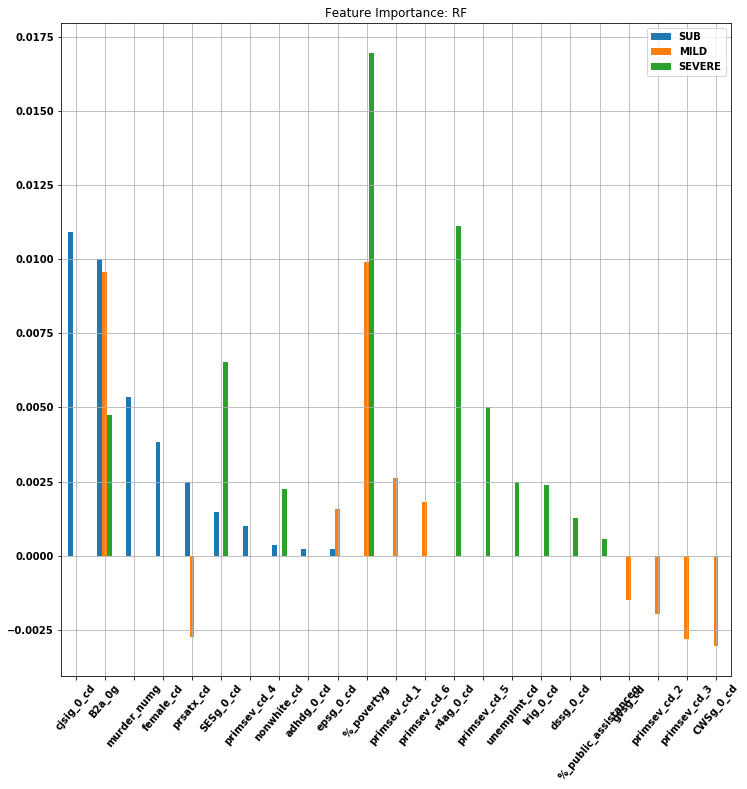

In [333]:
# feature importance for rf across all ages
feature_importance_rf = pd.DataFrame({'SUB': overall_feature_importance_rf['SUB'].tolist(),
                   'MILD': overall_feature_importance_rf['MILD'].tolist(),
                   'SEVERE': overall_feature_importance_rf['SEVERE'].tolist()},
                  index=overall_feature_importance_rf['Feature'].tolist())
feature_importance_rf.sort_values(by=['SUB','MILD','SEVERE'], ascending=False, inplace=True)
ax = feature_importance_rf.plot.bar(rot=50, figsize=(12, 12))
ax.grid()
ax.set_title('Feature Importance: RF')
fig = ax.get_figure()
    
fig.savefig('graphs/feature_importance_rf.png', bbox_inches='tight')

In [334]:
# features in top 10 of both models across all ages
feature_importance_intersection = np.intersect1d(overall_feature_importance_rf['Feature'], 
                                                 overall_feature_importance_lasso['Feature'])
print('Common Features:', *list(feature_importance_intersection), sep =', ')

Common Features:, %_povertyg, B2a_0g, CWSg_0_cd, SESg_0_cd, adhdg_0_cd, cjsig_0_cd, dssg_0_cd, gvsg_cd, lrig_0_cd, primsev_cd_4, primsev_cd_5, primsev_cd_6, prsatx_cd, r4ag_0_cd


In [335]:
# print out total notebook execution time
total_seconds = int(time.time() - start_time)
minutes = total_seconds // 60
seconds = total_seconds % 60
print("--- " + str(minutes) + " minutes " + str(seconds) + " seconds ---")

--- 13 minutes 35 seconds ---
